In [1]:
import numpy as np
from numba import njit
from tqdm.notebook import tqdm,trange
import numpy.linalg as la
import matplotlib.pyplot as plt

plt.rc('font',size=16)

from IPython.display import HTML
from matplotlib.animation import FuncAnimation
###### Flow definition #########################################################
MAX_ITER = 1000  # Total number of time iterations.
REYNOLDS = 220.0  # Reynolds number.
NX = 520
NY = 180
LY = NY-1.0
Q = 9  # Lattice dimensions and populations.
CX = NX/4
CY = NY/2
R = NY/9          # Coordinates of the cylinder.
U_LB = 0.04                       # Velocity in lattice units.
NU_LB = U_LB*R/REYNOLDS
OMEGA = 1.0 / (3.*NU_LB+0.5)  # Relaxation parameter.

In [2]:
###### Lattice Constants #######################################################
# Lattice velocities.
c = np.array([(x, y) for x in [0, -1, 1] for y in [0, -1, 1]])
t = 1./36. * np.ones(Q)                                   # Lattice weights.
t[np.asarray([la.norm(ci) < 1.1 for ci in c])] = 1./9.
t[0] = 4./9.
noslip = [c.tolist().index((-c[i]).tolist()) for i in range(Q)]
i1 = np.arange(Q)[np.asarray([ci[0] < 0 for ci in c])]  # Unknown on right wall.
i2 = np.arange(Q)[np.asarray([ci[0] == 0 for ci in c])]  # Vertical middle.
i3 = np.arange(Q)[np.asarray([ci[0] > 0 for ci in c])]  # Unknown on left wall.

In [3]:
# Helper function for density computation.
@njit
def sumpop(fin):
    return np.sum(fin, axis=0)

def equilibrium(rho, u):              # Equilibrium distribution function.
    cu = 3.0 * np.dot(c, u.transpose(1, 0, 2))
    usqr = 3./2.*(u[0]**2+u[1]**2)
    feq = np.zeros((Q, NX, NY))
    for i in range(Q):
        feq[i, :, :] = rho*t[i]*(1.+cu[i]+0.5*cu[i]**2-usqr)
    return feq

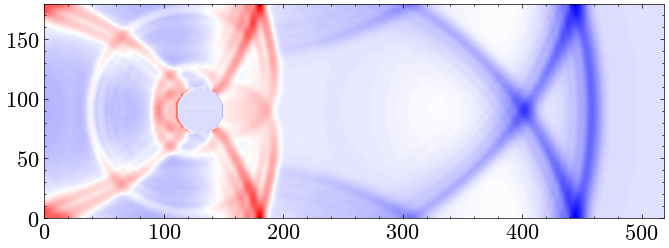

In [11]:
###### Setup: cylindrical obstacle and velocity inlet with perturbation ########
obstacle = np.fromfunction(lambda x, y: (x-CX)**2+(y-CY)**2 < R**2, (NX, NY))
vel = np.fromfunction(lambda d, x, y: (1-d)*U_LB *
                   (1.0+1e-4*np.sin(y/LY*2*np.pi)), (2, NX, NY))
feq = equilibrium(1.0, vel)
fin = feq.copy()
fin[i1, -1, :] = fin[i1, -2, :]  # Right wall: outflow condition.
rho = sumpop(fin)           # Calculate macroscopic density and velocity.
u = np.dot(c.transpose(), fin.transpose((1, 0, 2)))/rho

def update():
    global rho,u,fin,feq
    fin[i1, -1, :] = fin[i1, -2, :]  # Right wall: outflow condition.
    rho = sumpop(fin)           # Calculate macroscopic density and velocity.
    u = np.dot(c.transpose(), fin.transpose((1, 0, 2)))/rho

    # Left wall: compute density from known populations.
    u[:, 0, :] = vel[:, 0, :]
    rho[0, :] = 1./(1.-u[0, 0, :]) * \
        (sumpop(fin[i2, 0, :])+2.*sumpop(fin[i1, 0, :]))

    feq = equilibrium(rho, u)  # Left wall: Zou/He boundary condition.
    fin[i3, 0, :] = fin[i1, 0, :] + feq[i3, 0, :] - fin[i1, 0, :]
    fout = fin - OMEGA * (fin - feq)  # Collision step.
    for i in range(Q):
        fout[i, obstacle] = fin[noslip[i], obstacle]
    for i in range(Q):  # Streaming step.
        fin[i, :, :] = np.roll(
            np.roll(fout[i, :, :], c[i, 0], axis=0), c[i, 1], axis=1)

fig,ax = plt.subplots(figsize=(8,8))
cb = [ax.contourf(rho.transpose(),levels=128,cmap='bwr')]
ax.set_aspect('equal')

NFRAMES = 50

def animate(k):
    global rho,u,fin,feq
    ITERS = 10
    for _ in range(ITERS):
        update()
    for c in cb[0].collections:
        c.remove()
    cb[0] = ax.contourf(rho.transpose(),levels=128,cmap='bwr')

ani =FuncAnimation(fig,animate,frames=range(NFRAMES),interval=15)
HTML(ani.to_jshtml())